## Vehicle Detection and Tracking Project

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier (SVM or Decision Trees)
* Apply a color transform and append binned color features to the HOG feature vector.
* Experiment training your classifier on HOG / color features only, and then combination of the two
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Using a Decision Tree classifier, explore the feature importances and consider pruning or adding new features.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Estimate a bounding box for vehicles detected.
* Run your pipeline on a video stream and implement tracking to follow detected vehicles.
* Estimate distance and trajectory of detected vehicles.
---
## Step 1: make a list of images to read in

Data set includes a count of 8792  cars and 8968  non-cars


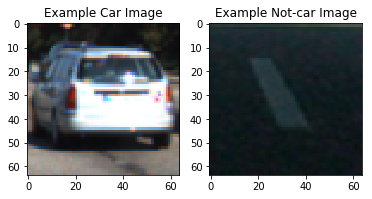

In [1]:
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
%matplotlib inline
# images are divided up into vehicles and non-vehicles folders (each of wich contains subfolder)
# First locate vehicle images
basedir = 'vehicles/'
# Different folders represent different sources for images e.g. GTI, Kitti, generated from video
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))

# Do the same thing for non-vehicle images
basedir = 'non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(cars[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Data set includes a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.savefig('./output_images/car_not_car.jpg')
plt.show()

## Feature extraction

In [2]:
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# NOTE: the last import is only valid for scikit-learn version >= 0.18
# for scikit-learn <= 0.18 use:
# from sklearn.cross_validation import train_test_split


In [3]:
# lesson_functions.py

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features
    
# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# I opted to get rid of bin range altogether and let it be automatic
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels seperately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the feature vector
    return hist_features

# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element

def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32,32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'LAB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        else: feature_image = np.copy(image)
            
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image,size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image,nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Train a classifier

In [4]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, LAB
spatial_size = (32,32) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

C:\Users\Pramuditha\Miniconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


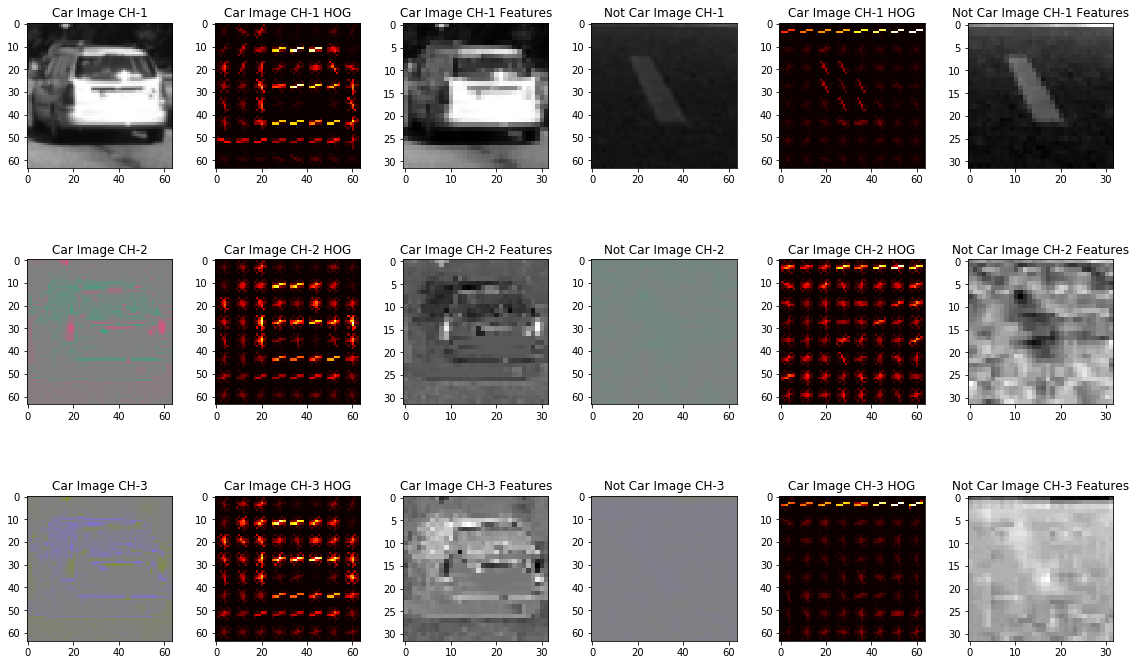

In [5]:
car_image_convert = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
notcar_image_convert = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YCrCb)
car_spatial_image = cv2.resize(car_image_convert, spatial_size)
notcar_spatial_image = cv2.resize(notcar_image_convert, spatial_size)

fig = plt.figure(figsize=(16,10))
for i in range(3):
    plt.subplot(3,6,i*6+1)
    draw_img = np.copy(car_image)
    draw_img[:,:,:] = 0.5
    draw_img[:,:,i] = car_image_convert[:,:,i]
    draw_img = cv2.cvtColor(draw_img, cv2.COLOR_YCrCb2RGB)
    plt.imshow(draw_img)
    plt.title('Car Image CH-'+str(i+1))
    car_hog_features, car_hog_image =  get_hog_features(car_image_convert[:,:,i], orient, pix_per_cell, cell_per_block, vis=True)
    plt.subplot(3,6,i*6+2)
    plt.imshow(car_hog_image, cmap='hot')
    plt.title('Car Image CH-'+str(i+1)+' HOG')
    plt.subplot(3,6,i*6+3)
    plt.imshow(car_spatial_image[:,:,i], cmap='gray')
    plt.title('Car Image CH-'+str(i+1)+' Features')
    plt.subplot(3,6,i*6+4)
    draw_img = np.copy(notcar_image)
    draw_img[:,:,:] = 0.5
    draw_img[:,:,i] = notcar_image_convert[:,:,i]
    draw_img = cv2.cvtColor(draw_img, cv2.COLOR_YCrCb2RGB)
    plt.imshow(draw_img)
    plt.title('Not Car Image CH-'+str(i+1))
    notcar_hog_features, notcar_hog_image =  get_hog_features(notcar_image_convert[:,:,i], orient, pix_per_cell, cell_per_block, vis=True)
    plt.subplot(3,6,i*6+5)
    plt.imshow(notcar_hog_image, cmap='hot')
    plt.title('Car Image CH-'+str(i+1)+' HOG')
    plt.subplot(3,6,i*6+6)
    plt.imshow(notcar_spatial_image[:,:,i], cmap='gray')
    plt.title('Not Car Image CH-'+str(i+1)+' Features')
fig.tight_layout()
plt.savefig('./output_images/HOG_example.jpg')

In [6]:
from sklearn import grid_search

t=time.time()
n_samples = 2000

random_idxs = np.random.randint(0,len(cars), n_samples)
test_cars = np.array(cars)[random_idxs]
test_notcars = np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=True, hist_feat=False, hog_feat=True)

notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient,
                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=True, hist_feat=False, hog_feat=True)
          
print(time.time()-t,'Seconds to compute features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
    
print('Using spatial binning of:', spatial_size)
print('Using:',orient,'orientations',pix_per_cell,
      'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
parameters = {'C':[0.1, 1, 10]}
svr = LinearSVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
print(clf.best_params_)


19.821902990341187 Seconds to compute features...
Using spatial binning of: (32, 32)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8364
Test Accuracy of SVC =  0.9862
{'C': 0.1}


In [7]:
import pickle

t=time.time()

test_cars = cars
test_notcars = notcars

car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient,
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=True, hist_feat=False, hog_feat=True)

notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient,
                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=True, hist_feat=False, hog_feat=True)
          
print(time.time()-t,'Seconds to compute features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
    
# Use a linear SVC
svc = LinearSVC(C=0.1)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

clf_params = {}
clf_params['clf'] = svc
clf_params['scaler'] = X_scaler
pickle.dump( clf_params, open( "svm_clf_params.p", "wb" ) )


67.04505062103271 Seconds to compute features...
23.01 Seconds to train SVC...
Test Accuracy of SVC =  0.9907


## Search for vehicles in images

In [8]:
# load a pe-trained svc model from a serialized (pickle) file
clf_pickle = pickle.load( open("svm_clf_params.p", "rb" ) )

# get attributes of our svc object
svc = clf_pickle["clf"]
X_scaler = clf_pickle["scaler"]

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, x_start_stop, y_start_stop, scale, cell_step, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, emit_all_windows=False):
    img_boxes = []
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],x_start_stop[0]:x_start_stop[1],:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = cell_step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or emit_all_windows == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left+x_start_stop[0],ytop_draw+y_start_stop[0]),(xbox_left+x_start_stop[0]+win_draw,ytop_draw+y_start_stop[0]+win_draw)))
                
    return img_boxes


C:\Users\Pramuditha\Miniconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


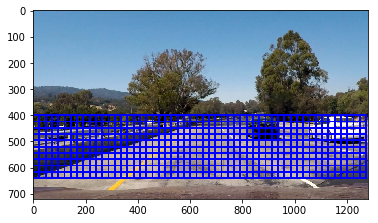

In [9]:
searchpath = 'test_images/test*'
example_images = glob.glob(searchpath)
x_start_stop = [None,None]
y_start_stop = [400,656]
scale = 1.5
cells_per_step = 2

img = mpimg.imread(example_images[0])
draw_img = np.copy(img)
img = img.astype(np.float32)/255
img_boxes = find_cars(img, x_start_stop, y_start_stop, scale, cells_per_step, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, emit_all_windows=True)
out_img = draw_boxes(draw_img, img_boxes)
plt.imshow(out_img)
plt.savefig('./output_images/sliding_windows.jpg')
plt.show()

C:\Users\Pramuditha\Miniconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


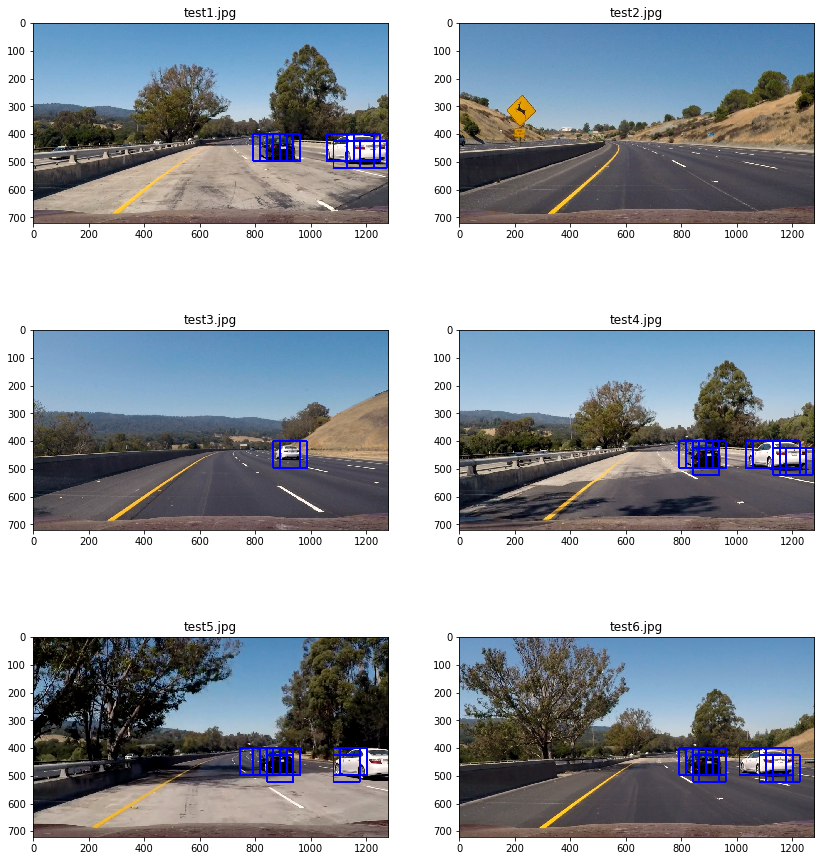

In [10]:
fig, ax = plt.subplots(int(len(example_images)/2),2)
fig.set_size_inches(14,16)
i = 0    
for img_src in example_images:
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_boxes = find_cars(img, x_start_stop, y_start_stop, scale, cells_per_step, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size)
    out_img = draw_boxes(draw_img, img_boxes)
    ax[int(i/2)][int(i%2)].imshow(out_img)
    ax[int(i/2)][int(i%2)].set_title(img_src.split('\\')[-1])
    i+=1
plt.savefig('./output_images/sliding_window.jpg')
plt.show()

## Estimate a bounding box for vehicles detected

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [12]:
from scipy.ndimage.measurements import label

class VehicleTracker():
     # when starting a new instance please be sure to specify all unassigned variables
    def __init__(self, search_regions, search_scales, cells_per_step, clf, scaler, feature_params, smooth_factor=3, threshold=1, key_frame_interval=1):
        self.regions = search_regions
        self.scales = search_scales
        self.cell_step = cells_per_step
        self.svc = clf
        self.X_scaler = scaler
        self.feature_params = feature_params
        self.smooth_factor = smooth_factor
        self.threshold = threshold
        self.recent_windows = []
        self.integrated_heatmap = None
        self.labels = None
        self.frame_interval = key_frame_interval
        self.frame = 0
        
    def find_vehicles(self, img):
        orient = self.feature_params['orient']
        pix_per_cell = self.feature_params['pix_per_cell']
        cell_per_block = self.feature_params['cell_per_block']
        spatial_size = self.feature_params['spatial_size']
        heatmap = np.zeros_like(img[:,:,0])
        if self.frame%self.frame_interval > 0 and self.labels[1] >= 1:
            # Find pixels with label values
            nonzero = (self.labels[0] > 0).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            min_x = max(0,np.min(nonzerox)-32)
            max_x = min(img.shape[1],np.max(nonzerox)+32)-1
            min_y = max(0,np.min(nonzeroy)-32)
            max_y = min(img.shape[0],np.max(nonzeroy)+32)-1
            for scale in self.scales:
                img_boxes = find_cars(img, [min_x,max_x], [min_y,max_y], scale, self.cell_step, self.svc, self.X_scaler, orient, pix_per_cell, cell_per_block, spatial_size) 
                self.recent_windows.append(img_boxes) 
        else:
            for search_region, scale in zip(self.regions,self.scales):
                img_boxes = find_cars(img, search_region[0], search_region[1], scale, self.cell_step, self.svc, self.X_scaler, orient, pix_per_cell, cell_per_block, spatial_size) 
                self.recent_windows.append(img_boxes)        
        for i in range(min(len(self.recent_windows),self.smooth_factor*len(self.scales))):
            add_heat(heatmap,self.recent_windows[-i])
        if len(self.recent_windows) > self.smooth_factor*2*len(self.scales):
            self.recent_windows = self.recent_windows[-self.smooth_factor*2*len(self.scales):] # clip off to reduce memory
        apply_threshold(heatmap,min(len(self.recent_windows),self.threshold))
        self.integrated_heatmap = heatmap
        self.labels = label(heatmap)
        self.frame += 1
        return self.labels

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

i = 1
myclip = VideoFileClip('test_video.mp4')
for frame in myclip.iter_frames():
    if(i>30):
        cv2.imwrite('./test_images/img'+str(i)+'.jpg',cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    i+=1

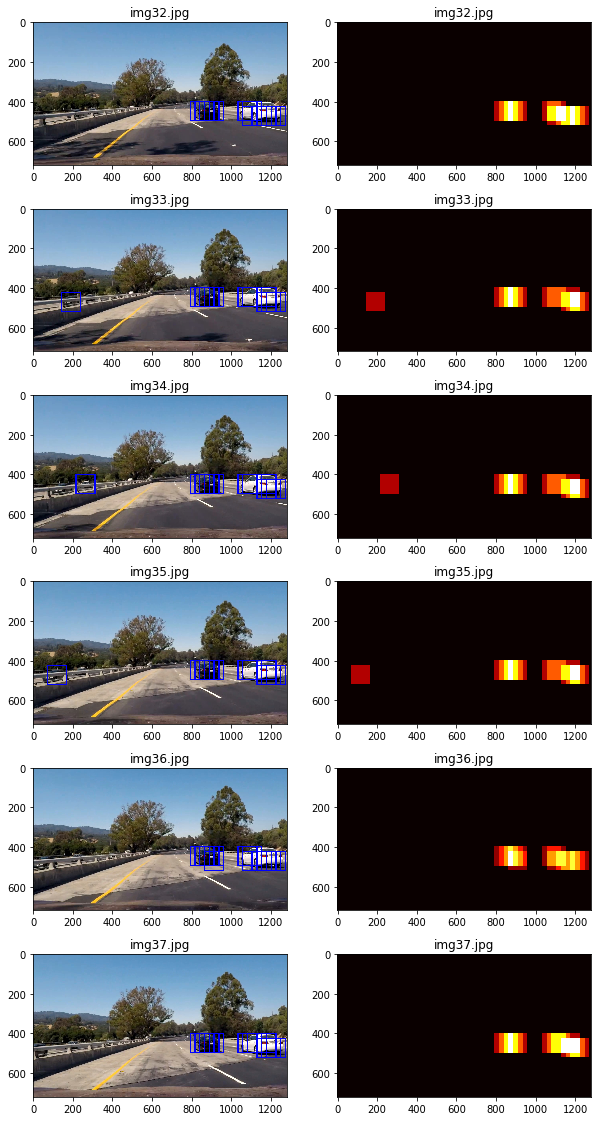

Labels map


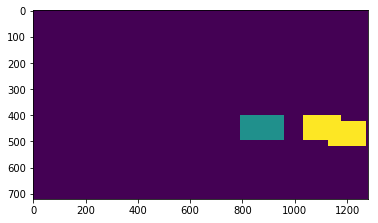

Output


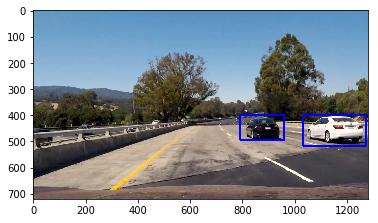

In [14]:
fig, ax = plt.subplots(6,2)
fig.set_size_inches(10,20)

integrated_heatmap = None
for i in range(6):
    img_src = './test_images/img'+str(i+32)+'.jpg'
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_boxes = find_cars(img, x_start_stop, y_start_stop, scale, cells_per_step, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size)
    out_img = draw_boxes(draw_img, img_boxes)
    ax[i][0].imshow(out_img)
    ax[i][0].set_title(img_src.split('/')[-1])
    heatmap = np.zeros_like(img[:,:,0])
    add_heat(heatmap, img_boxes)
    if integrated_heatmap is None:
        integrated_heatmap = heatmap
    else:
        add_heat(integrated_heatmap, img_boxes)
    ax[i][1].imshow(heatmap, cmap='hot')
    ax[i][1].set_title(img_src.split('/')[-1])
    i+=1
plt.savefig('./output_images/bboxes_and_heat.jpg')
plt.show()
print("Labels map")
apply_threshold(integrated_heatmap,4)
labels = label(integrated_heatmap)
plt.imshow(labels[0])
plt.savefig('./output_images/labels_map.jpg')
plt.show()
print("Output")
img_src = './test_images/img37.jpg'
draw_img = mpimg.imread(img_src)
draw_img = draw_labeled_bboxes(draw_img, labels)
plt.imshow(draw_img)
plt.savefig('./output_images/output_bboxes.jpg')
plt.show()

In [15]:
def process_image2(img, tracker):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    labels = tracker.find_vehicles(img)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(draw_img, labels)
    return draw_img

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Output_video = 'project_video_output.mp4'
Input_video = 'project_video.mp4'

# Set parameters for feature extraction
feature_params={}
feature_params['orient'] = orient
feature_params['pix_per_cell'] = pix_per_cell
feature_params['cell_per_block'] = cell_per_block
feature_params['spatial_size'] = spatial_size

tracker_params={}
tracker_params['search_regions'] = [[x_start_stop,y_start_stop]]
tracker_params['search_scales'] = [1.5]
tracker_params['cells_per_step'] = 2
tracker_params['smooth_factor'] = 8
tracker_params['threshold'] = 2
tracker_params['key_frame_interval'] = 2

# Set up the overall class to do all the tracking
vehicles = VehicleTracker(tracker_params['search_regions'], tracker_params['search_scales'], tracker_params['cells_per_step'], svc, X_scaler, feature_params, tracker_params['smooth_factor'], tracker_params['threshold'], tracker_params['key_frame_interval'])
def process_video_clip(clip, tracker):
    def process_frame(image):
        return process_image2(image, tracker)
    return clip.fl_image(process_frame) #NOTE: this function expects color images!!

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fx(process_video_clip,vehicles)
video_clip.write_videofile(Output_video, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:05<00:00,  6.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



## Combined pipeline

In [17]:
from image_gen import process_image
from pipeline import pipeline 
from tracker import LineTracker
from multiprocessing.pool import ThreadPool

pool = ThreadPool(processes=1)


def process_combined(img,dist_pickle, src, dst, thresholds, lane_tracker, vehicle_tracker):
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    # undistort the image
    image = cv2.undistort(img,mtx,dist,None,mtx)

    result = pool.apply_async(process_image, (image, src, dst, thresholds, lane_tracker))
    image = image.astype(np.float32)/255
    labels = vehicle_tracker.find_vehicles(image)
    result_img = result.get()
    # Draw bounding boxes on a copy of the image
    result_img = draw_labeled_bboxes(result_img, labels)
    
    return result_img

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Output_video = 'project_video_combined_output.mp4'
Input_video = 'project_video.mp4'

cal_image_path = "camera_cal/"

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load(open(cal_image_path+"dist_pickle.p", "rb" ))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

src = np.float32([[252,698],[573,465],[712,465],[1064,698]])
dst = np.float32([[412,720],[412,0],[888,0],[888,720]])

# Set thresholds for pipeline
thresholds = {}
thresholds['l_thresh']=(210, 255)
thresholds['b_thresh']=(170, 255)
thresholds['grad_thresh']=(10, 255)
thresholds['dir_thresh']=(np.pi*0.10, np.pi*0.40)

line_tracker_params = {}
line_tracker_params['window_width']=40
line_tracker_params['window_height']=80
line_tracker_params['margin']=40
line_tracker_params['ym_per_pix']=25/720
line_tracker_params['xm_per_pix']=3.7/(dst[2][0]-dst[1][0])

tracker_params['smooth_factor'] = 8
tracker_params['threshold'] = 7

# Set up the overall class to do all the tracking
line_tracker_params['smooth_factor']=5
curve_centers = LineTracker(window_width = line_tracker_params['window_width'], window_height = line_tracker_params['window_height'], margin = line_tracker_params['margin'], ym = line_tracker_params['ym_per_pix'], xm = line_tracker_params['xm_per_pix'], smooth_factor=line_tracker_params['smooth_factor'])
vehicles = VehicleTracker(tracker_params['search_regions'], tracker_params['search_scales'], tracker_params['cells_per_step'], svc, X_scaler, feature_params, tracker_params['smooth_factor'], tracker_params['threshold'], tracker_params['key_frame_interval'])

def process_video_clip2(clip,dist_pickle, src, dst, thresholds, lane_tracker, vehicle_tracker):
    def process_frame2(image):
        return process_combined(image,dist_pickle, src, dst, thresholds, lane_tracker, vehicle_tracker)
    return clip.fl_image(process_frame2) #NOTE: this function expects color images!!

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fx(process_video_clip2,dist_pickle, src, dst,thresholds,curve_centers,vehicles)
video_clip.write_videofile(Output_video, audio=False)

[MoviePy] >>>> Building video project_video_combined_output.mp4
[MoviePy] Writing video project_video_combined_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:01<00:00,  4.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_combined_output.mp4 

